In [41]:
# Importing the libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as stats
import json
import copy

In [42]:
with open('../models/config.json', 'r') as f:
    config = json.load(f)

preprocess = config['preprocessing']

In [43]:
# Output Path
OUTPUT_PATH =preprocess['output_path']

# Input Path
INPUT_PATH = preprocess['input_path']

In [44]:
# Load the dataset
dataset = pd.read_csv(INPUT_PATH + '240624_validation_data.csv')


In [45]:
# Select the date for which you want to extract the data
selected_date = '2023-04-02'

# Number of scenarios to generate
num_scenarios = 20
desired_num_scenarios = 10

In [46]:
# Extract the time, forecasted demand and actual demand
time = dataset['time']
time = pd.to_datetime(time, utc=True)
forecast_demand = dataset['predicted heat']
actual_demand = dataset['delivered heat']

# Create a dataframe with the necessary columns
df_data = pd.DataFrame({'time' : time, 'actual_demand': actual_demand, 'forecast_demand': forecast_demand})
df_data['hour']=time.dt.hour

# Calculate the error and absolute error
df_data['error']= df_data['actual_demand'] - df_data['forecast_demand']

# Calculate the mean of the error for whole dataset
mu_all = df_data['error'].mean()
sigma_all = df_data['error'].std()
print('Mean of of the error of each hour:', mu_all)
print('Standard deviation of the mean of the error of each hour:', sigma_all)

df_data

Mean of of the error of each hour: -8.39020298257356
Standard deviation of the mean of the error of each hour: 31.42172005784749


,time,actual_demand,forecast_demand,hour,error
0,2023-03-02 16:00:00+00:00,254.990005,255.590651,16,-0.600646
1,2023-03-02 17:00:00+00:00,187.787503,237.501176,17,-49.713673
2,2023-03-02 18:00:00+00:00,230.629171,264.220971,18,-33.591800
3,2023-03-02 19:00:00+00:00,233.329169,236.491860,19,-3.162691
4,2023-03-02 20:00:00+00:00,222.775003,216.179837,20,6.595167
...,...,...,...,...,...
2996,2023-07-12 19:00:00+00:00,55.804167,51.912949,19,3.891219
2997,2023-07-12 20:00:00+00:00,14.191667,37.334409,20,-23.142742
2998,2023-07-12 21:00:00+00:00,22.533334,37.278034,21,-14.744700
2999,2023-07-12 22:00:00+00:00,15.287500,37.703201,22,-22.415700


In [47]:
# Calculate the mean and standard deviation of the error of each hour of a day. 
error = df_data.groupby('hour')['error'].agg(['mean', 'std']).reset_index()
error  = error.rename(columns={'mean': 'mu', 'std': 'sigma'})

# Save the error data to a dictionary
error_dict = error.set_index('hour').to_dict(orient='index')

# Print the error dictionary
error_dict


{0: {'mu': -12.731658021190215, 'sigma': 25.018753157221795},
 1: {'mu': -8.717701939869812, 'sigma': 25.787822594592562},
 2: {'mu': 38.62809145641247, 'sigma': 40.06221098717317},
 3: {'mu': -11.219355528775246, 'sigma': 35.89610812413864},
 4: {'mu': 4.6619634940865975, 'sigma': 29.89150310430875},
 5: {'mu': -3.1503448513536596, 'sigma': 30.62503489088334},
 6: {'mu': -11.665524616604312, 'sigma': 28.687483429676817},
 7: {'mu': -8.965185204385374, 'sigma': 30.89163216771525},
 8: {'mu': -4.254730131452734, 'sigma': 29.0944311173442},
 9: {'mu': -9.849400683302798, 'sigma': 33.982800569041345},
 10: {'mu': -16.93716965553407, 'sigma': 31.972997351520558},
 11: {'mu': -11.808679656691835, 'sigma': 27.301664271959485},
 12: {'mu': -14.417149987864374, 'sigma': 29.132160670687032},
 13: {'mu': -11.036739802937781, 'sigma': 27.055038468354763},
 14: {'mu': -14.235238982654698, 'sigma': 29.627671262886945},
 15: {'mu': -12.303575238253774, 'sigma': 33.18363957415679},
 16: {'mu': -7.271

In [48]:
# Extract the data for the selected date
daily_date = df_data[df_data['time'].dt.date == pd.to_datetime(selected_date).date()].reset_index(drop=True)
daily_date = daily_date[['time', 'hour', 'actual_demand', 'forecast_demand', 'error']]
if(len(daily_date)==24):
    print('The selected date has 24 hours')
else:
    print('The selected date does not have 24 hours')
daily_date

The selected date has 24 hours


,time,hour,actual_demand,forecast_demand,error
0,2023-04-02 00:00:00+00:00,0,105.950002,86.890206,19.059796
1,2023-04-02 01:00:00+00:00,1,137.445836,102.670129,34.775707
2,2023-04-02 02:00:00+00:00,2,281.025006,197.108180,83.916826
3,2023-04-02 03:00:00+00:00,3,158.920836,131.411104,27.509732
4,2023-04-02 04:00:00+00:00,4,175.820836,134.362787,41.458049
5,2023-04-02 05:00:00+00:00,5,176.595835,133.354884,43.240951
6,2023-04-02 06:00:00+00:00,6,225.187504,148.670828,76.516676
7,2023-04-02 07:00:00+00:00,7,194.391670,155.766129,38.625540
8,2023-04-02 08:00:00+00:00,8,202.875005,149.413352,53.461652
9,2023-04-02 09:00:00+00:00,9,208.116669,132.527995,75.588675


---

## Methode: Monte Carlo Sampling and Roulette Wheel Mechanism


In [49]:
import numpy as np
import random
from scipy import stats

# Number of intervals
num_intervals = 7

# Store the data
scenarios = []
scenario_probabilities = []
heat_demand_data = {}
heat_data_test = {}

# Function to randomly select an interval based on the CDF
def select_interval(cumulative_probabilities):
    rnd = random.random()
    for i, cp in enumerate(cumulative_probabilities):
        if rnd <= cp:
            return i
    return len(cumulative_probabilities) - 1

# Generate scenarios
for scenario_index in range(num_scenarios):
    scenario_name = f"Scenario{scenario_index + 1}"
    scenario = []
    scenario_probability = 1
    
    for t in range(len(daily_date)):
        mu = error_dict[t]['mu']
        sigma = error_dict[t]['sigma']
        
        # Define the intervals
        intervals = np.linspace(mu - 3 * sigma, mu + 3 * sigma, num_intervals + 1)
        interval_centers = (intervals[:-1] + intervals[1:]) / 2
        
        # Calculate probabilities for each interval
        probabilities = [
            stats.norm.cdf(intervals[i + 1], mu, sigma) - stats.norm.cdf(intervals[i], mu, sigma)
            for i in range(len(intervals) - 1)
        ]
        cum_probabilities = np.cumsum(probabilities)
        
        # Select interval index based on cumulative probabilities
        interval_index = select_interval(cum_probabilities)
        
        # Calculate forecast error and add to forecast demand
        forecast_error = interval_centers[interval_index]
        actual_demand = daily_date['forecast_demand'][t] + forecast_error
        scenario.append(actual_demand)
        
        # Multiply the probability of this interval to the scenario probability
        scenario_probability *= probabilities[interval_index]
    
    # Store the scenario and its probability in the dictionary
    heat_demand_data[scenario_name] = {
        "Probability": scenario_probability,
        **{t + 1: value for t, value in enumerate(scenario)}
    }
    heat_data_test[scenario_name] = {
        "Probability": scenario_probability,
        "Values": scenario
    }

    # Collect scenario probabilities for normalization
    scenario_probabilities.append(scenario_probability)

# Normalizing the scenario probabilities
total_probability = sum(scenario_probabilities)
for scenario_name in heat_demand_data:
    heat_demand_data[scenario_name]["Probability"] /= total_probability

#heat_demand_data

#Output the scenarios and their normalized probabilities
for scenario_name, data in heat_demand_data.items():
    print(f"{scenario_name}:")
    print(f"Normalized Probability: {data['Probability']:.4f}")
    print(f"Values: {[data[t + 1] for t in range(len(daily_date))]}")

heat_demand_data
heat_data_test

Scenario1:
Normalized Probability: 0.0033
Values: [np.float64(74.15854780013265), np.float64(116.05627513486333), np.float64(270.0753095429477), np.float64(89.42365604590086), np.float64(164.64603863979465), np.float64(103.95450937665474), np.float64(112.41603177991018), np.float64(120.32240239695605), np.float64(195.0347899614104), np.float64(64.42236475295142), np.float64(111.25096374568923), np.float64(65.27362472317373), np.float64(80.85853443616932), np.float64(94.99883401423591), np.float64(130.6125590589945), np.float64(182.7060801845854), np.float64(162.38762462254167), np.float64(204.46390451345837), np.float64(162.85261967291171), np.float64(135.41598450930172), np.float64(64.89301075562557), np.float64(105.79251653986543), np.float64(125.72721612021473), np.float64(93.25702422246873)]
Scenario2:
Normalized Probability: 0.0023
Values: [np.float64(52.7139022367997), np.float64(49.744731320196735), np.float64(270.0753095429477), np.float64(89.42365604590086), np.float64(139.024

{'Scenario1': {'Probability': np.float64(1.4017855181678752e-16),
  'Values': [np.float64(74.15854780013265),
   np.float64(116.05627513486333),
   np.float64(270.0753095429477),
   np.float64(89.42365604590086),
   np.float64(164.64603863979465),
   np.float64(103.95450937665474),
   np.float64(112.41603177991018),
   np.float64(120.32240239695605),
   np.float64(195.0347899614104),
   np.float64(64.42236475295142),
   np.float64(111.25096374568923),
   np.float64(65.27362472317373),
   np.float64(80.85853443616932),
   np.float64(94.99883401423591),
   np.float64(130.6125590589945),
   np.float64(182.7060801845854),
   np.float64(162.38762462254167),
   np.float64(204.46390451345837),
   np.float64(162.85261967291171),
   np.float64(135.41598450930172),
   np.float64(64.89301075562557),
   np.float64(105.79251653986543),
   np.float64(125.72721612021473),
   np.float64(93.25702422246873)]},
 'Scenario2': {'Probability': np.float64(9.871460528990323e-17),
  'Values': [np.float64(52.71

In [50]:
# Speichern des Dictionaries in einer JSON-Datei
selected_date = selected_date.replace('-', '')
print(selected_date)


with open(f'{OUTPUT_PATH}heat_demand_scenarios_{selected_date}.json', 'w') as json_file:
    json.dump(heat_demand_data, json_file, indent=4)

# Laden des Dictionaries aus der JSON-Datei
with open(f'{OUTPUT_PATH}heat_demand_scenarios_{selected_date}.json', 'r') as json_file:
    loaded_data = json.load(json_file)

forecast_demand_dict = {
    "heat_demand": {t + 1: demand for t, demand in daily_date['forecast_demand'].items()}
}

# Save to JSON file
with open(f'{OUTPUT_PATH}heat_demand_{selected_date}.json', 'w') as json_file:
    json.dump(forecast_demand_dict, json_file, indent=4)


print(loaded_data)

20230402
{'Scenario1': {'Probability': 0.003325635395053964, '1': 74.15854780013265, '2': 116.05627513486333, '3': 270.0753095429477, '4': 89.42365604590086, '5': 164.64603863979465, '6': 103.95450937665474, '7': 112.41603177991018, '8': 120.32240239695605, '9': 195.0347899614104, '10': 64.42236475295142, '11': 111.25096374568923, '12': 65.27362472317373, '13': 80.85853443616932, '14': 94.99883401423591, '15': 130.6125590589945, '16': 182.7060801845854, '17': 162.38762462254167, '18': 204.46390451345837, '19': 162.85261967291171, '20': 135.41598450930172, '21': 64.89301075562557, '22': 105.79251653986543, '23': 125.72721612021473, '24': 93.25702422246873}, 'Scenario2': {'Probability': 0.0023419330639822475, '1': 52.7139022367997, '2': 49.744731320196735, '3': 270.0753095429477, '4': 89.42365604590086, '5': 139.02475026467286, '6': 130.20453928312617, '7': 161.5945748022133, '8': 120.32240239695605, '9': 170.09670614654394, '10': 93.55047952641544, '11': 111.25096374568923, '12': 135.47

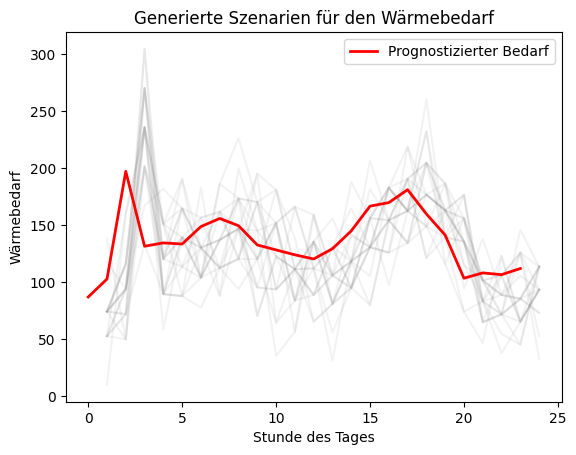

In [51]:
# Convert scenarios to DataFrame for plotting
scenarios_df = pd.DataFrame({name: data for name, data in heat_demand_data.items()}).drop('Probability').T

# Plot all scenarios and forecast demand
plt.plot(scenarios_df.T, color='grey', alpha=0.1)  # alle Szenarien plotten
plt.plot(daily_date['forecast_demand'], color='red', linewidth=2, label='Prognostizierter Bedarf')
plt.xlabel('Stunde des Tages')
plt.ylabel('Wärmebedarf')
plt.title('Generierte Szenarien für den Wärmebedarf')
plt.legend()
plt.show()

---

## Szenarien Reduktion

### Backward Scenario Reduction Methode

In [64]:
import numpy as np
import copy

# Initialize the set of scenarios S and the set of deleted scenarios DS
S = copy.deepcopy(heat_demand_data)  # Current scenarios
DS = {}  # Deleted scenarios

# Extract the scenario names
scenario_names = list(S.keys())
num_scenarios = len(scenario_names)

# Extract the time periods from one of the scenarios (assuming all have the same keys)
time_periods = sorted([key for key in S[scenario_names[0]].keys() if isinstance(key, int)])

# Precompute the distances between all scenario pairs
distance_matrix = np.zeros((num_scenarios, num_scenarios))

for i in range(num_scenarios):
    for j in range(i + 1, num_scenarios):
        s1 = [S[scenario_names[i]][t] for t in time_periods]
        s2 = [S[scenario_names[j]][t] for t in time_periods]
        # Compute the Euclidean distance (square root of the sum of squared differences)
        distance = np.sqrt(sum((v1 - v2) ** 2 for v1, v2 in zip(s1, s2)))
        distance_matrix[i, j] = distance
        distance_matrix[j, i] = distance  # Symmetric matrix

# Perform the scenario reduction
while len(S) > desired_num_scenarios:
    # Step 2: For each scenario nk, determine nr with minimum distance DTk,r
    nearest_neighbor = {}
    for k_idx in range(num_scenarios):
        k_name = scenario_names[k_idx]
        if k_name not in S:
            continue
        distances = [
            (distance_matrix[k_idx, s_idx], scenario_names[s_idx])
            for s_idx in range(num_scenarios)
            if scenario_names[s_idx] in S and s_idx != k_idx
        ]
        if distances:
            min_distance, r_name = min(distances, key=lambda x: x[0])
            nearest_neighbor[k_name] = (min_distance, r_name)
    
    # Step 3: Calculate PDk,r = Pr(k) * DTk,r
    PD = {}
    for k_name in nearest_neighbor:
        Pr_k = S[k_name]["Probability"]
        DTk_r, r_name = nearest_neighbor[k_name]
        PD_k_r = Pr_k * DTk_r
        PD[k_name] = (PD_k_r, r_name)
    
    # Select d for which PDd = min PDk
    d_name, (min_PDd, r_name) = min(PD.items(), key=lambda x: x[1][0])
    
    # Step 4: Remove nd from S, add nd to DS, adjust probabilities
    Pr_d = S[d_name]["Probability"]
    Pr_r = S[r_name]["Probability"]
    S[r_name]["Probability"] = Pr_r + Pr_d
    DS[d_name] = S.pop(d_name)
    
    # Update the scenario names and number of scenarios
    scenario_names = list(S.keys())
    num_scenarios = len(scenario_names)

# The reduced set of scenarios is now in S
# Normalize the probabilities again to ensure they sum to 1
total_probability = sum(scenario["Probability"] for scenario in S.values())
for scenario in S.values():
    scenario["Probability"] /= total_probability

# Output the reduced scenarios and their probabilities
print("\nReduced Scenarios:")
for scenario_name, data in S.items():
    print(f"{scenario_name}:")
    print(f"  Normalized Probability: {data['Probability']:.4f}")
    scenario_values = [data[t] for t in time_periods]
    print(f"  Values: {scenario_values}")


[np.float64(74.15854780013265), np.float64(116.05627513486333), np.float64(270.0753095429477), np.float64(89.42365604590086), np.float64(164.64603863979465), np.float64(103.95450937665474), np.float64(112.41603177991018), np.float64(120.32240239695605), np.float64(195.0347899614104), np.float64(64.42236475295142), np.float64(111.25096374568923), np.float64(65.27362472317373), np.float64(80.85853443616932), np.float64(94.99883401423591), np.float64(130.6125590589945), np.float64(182.7060801845854), np.float64(162.38762462254167), np.float64(204.46390451345837), np.float64(162.85261967291171), np.float64(135.41598450930172), np.float64(64.89301075562557), np.float64(105.79251653986543), np.float64(125.72721612021473), np.float64(93.25702422246873)]
[np.float64(52.7139022367997), np.float64(49.744731320196735), np.float64(270.0753095429477), np.float64(89.42365604590086), np.float64(139.02475026467286), np.float64(130.20453928312617), np.float64(161.5945748022133), np.float64(120.32240239